# Proyecto 3 - G3 - ML

Introducción.....

## 0. Libraries

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn import preprocessing
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
import umap
import math
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import pdist, squareform
import time




np.random.seed(2024)

## 1. Video Features Extracion

Para la extracción de features se usó la librería **Video Features**. No se escogió **Gluon** porque no ha tenido mantenimiento desde hace más de 1 año. 

Modelos disponibles: 

- S3D (Kinetics 400)
- R(2+1)d RGB (IG-65M, Kinetics 400):
    - r2plus1d_18_16_kinetics
    - r2plus1d_34_32_ig65m_ft_kinetics *
    - r2plus1d_34_8_ig65m_ft_kinetics
- I3D-Net RGB + Flow (Kinetics 400)

Al final obtuvimos un conjunto de .npy, los cuales leeremos y 

El comando usado fue el siguiente:

```bash
# para usar con cpu agregar argumento
python .... device="cpu"

# i3d
python main.py feature_type=i3d file_with_video_paths="../data/train_subset/video_paths.txt" on_extraction=save_numpy output_path="../data/train_output"

# s3d
python main.py feature_type=s3d file_with_video_paths="../data/train_subset/video_paths.txt" on_extraction=save_numpy output_path="../data/train_output"

# r2plus1d_18_16_kinetics
python main.py feature_type=r21d file_with_video_paths="../data/train_subset/video_paths.txt" model_name="r2plus1d_18_16_kinetics" on_extraction=save_numpy output_path="../data/train_output"
-----
# r2plus1d_34_32_ig65m_ft_kinetics
python main.py feature_type=r21d file_with_video_paths="../data/train_subset/video_paths.txt" model_name="r2plus1d_34_32_ig65m_ft_kinetics" on_extraction=save_numpy output_path="../data/train_output"
------
# r2plus1d_34_8_ig65m_ft_kinetics
python main.py feature_type=r21d file_with_video_paths="../data/train_subset/video_paths.txt" model_name="r2plus1d_34_8_ig65m_ft_kinetics" on_extraction=save_numpy output_path="../data/train_output"
```

# 2. Load & Save Feature Vectors

In [2]:
def extract_video_data(video_features_path, labels_df):
    video_features = []
    video_labels = []
    video_empty_frames = 0
    
    for each_video in glob.glob(os.path.join(video_features_path, '*.npy')):
        youtube_id = os.path.basename(each_video).split('_')[0]
        current_video_feature = np.load(each_video)

        if current_video_feature.size == 0:
            video_empty_frames += 1
            continue

        
        current_video_feature_avg = np.mean(current_video_feature, axis = 0)
        
        video_features.append(current_video_feature_avg)

        current_video_label = labels_df[labels_df['youtube_id'] == youtube_id]['label'].values[0]
        video_labels.append(current_video_label)

    print(f'Número de videos vacíos no agregados ({video_features_path}): {video_empty_frames}')    
    
    video_features_stacked = np.vstack(video_features)
    video_labels_stacked = np.vstack(video_labels)
    
    df_features = pd.DataFrame(video_features_stacked)
    df_labels = pd.DataFrame(video_labels_stacked)

    return df_features, df_labels



In [3]:
df_train_labels = pd.read_csv('./data/train_subset.csv', header = None, names = ['youtube_id', 'label'])
df_val_labels = pd.read_csv('./data/val_subset.csv', header = None, names = ['youtube_id', 'label'])

X_train, Y_train = extract_video_data('./data/train_output/r21d/r2plus1d_34_32_ig65m_ft_kinetics', df_train_labels)
X_train.dropna(inplace = True)
Y_train.dropna(inplace = True)

print(f'\nNúmero de videos cargados para entrenamiento: {len(X_train)}')
print(f'Shape de nuestra matriz de videos para entrenamiento: {X_train.shape}')

Número de videos vacíos no agregados (./data/train_output/r21d/r2plus1d_34_32_ig65m_ft_kinetics): 15

Número de videos cargados para entrenamiento: 10680
Shape de nuestra matriz de videos para entrenamiento: (10680, 512)


In [87]:
scaler = PowerTransformer(method='yeo-johnson')
normalized_data = scaler.fit_transform(X_train)

In [6]:
le = preprocessing.LabelEncoder()
le.fit(Y_train.to_numpy().ravel())
Y_train_encoded = le.transform(Y_train.to_numpy().ravel())

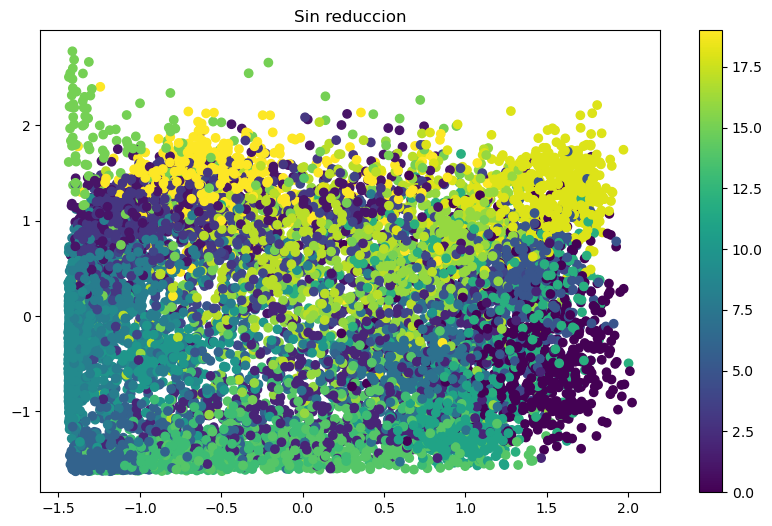

In [89]:
# Asumamos que normalized_data tiene al menos dos características
plt.figure(figsize=(10, 6))
plt.scatter(normalized_data[:, 0], normalized_data[:, 1], c=Y_train_encoded, cmap='viridis')
plt.title('Sin reduccion')
plt.colorbar()
plt.show()

In [ ]:

start_time = time.time()
umap_reducer = umap.UMAP(n_components=2)
umap_data = umap_reducer.fit_transform(normalized_data)
end_time = time.time()
print(f"Tiempo de ejecución de UMAP: {end_time - start_time:.2f} segundos")

Tiempo de ejecución de UMAP: 5.46 segundos


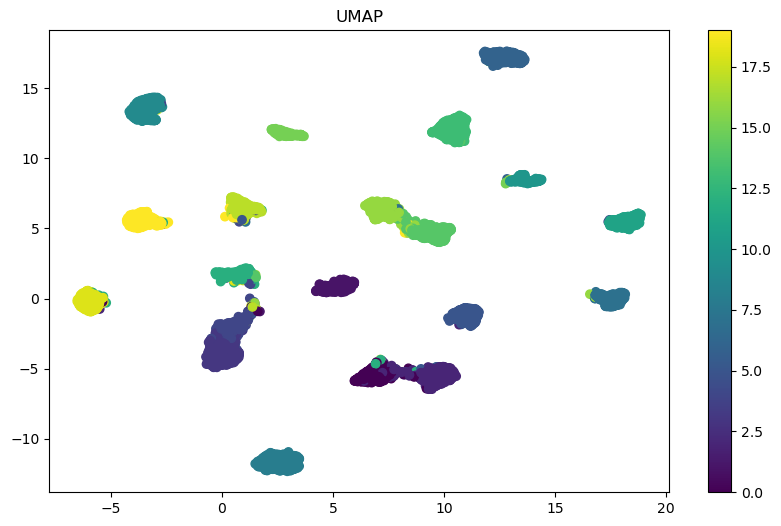

In [91]:

plt.figure(figsize=(10, 6))
plt.scatter(umap_data[:, 0], umap_data[:, 1], c=Y_train_encoded, cmap='viridis')
plt.title('UMAP')
plt.colorbar()
plt.show()

In [92]:
def evaluate_clustering(reduced_data, true_labels, method_name, clustering_algorithm='kmeans'):
    if clustering_algorithm == 'kmeans':
        clusterer = KMeans(n_clusters=20, random_state=2024, algorithm='lloyd')
    elif clustering_algorithm == 'meanshift':
        clusterer = MeanShift()
    elif clustering_algorithm == 'dbscan':
        clusterer = DBSCAN(eps=0.5, min_samples=4)
    elif clustering_algorithm == 'agglomerative':
        clusterer = AgglomerativeClustering(n_clusters=20)

    predicted_labels = clusterer.fit_predict(reduced_data)
    
    silhouette_avg = silhouette_score(reduced_data, predicted_labels)
    ari = adjusted_rand_score(true_labels, predicted_labels)
    ami = adjusted_mutual_info_score(true_labels, predicted_labels)

    print(f"{method_name} ({clustering_algorithm}) - Silhouette Score: {silhouette_avg:.4f}, Adjusted Rand Index: {ari:.4f}, Adjusted Mutual Information: {ami:.4f}")

In [93]:


def get_distance_measure(M):
    if M == 'euclidean':
        return lambda cluster1, cluster2: np.linalg.norm(np.mean(cluster1, axis=0) - np.mean(cluster2, axis=0))
    return None

class AgglomerativeHierarchicalClustering:
    def __init__(self, data, K, M='euclidean'):
        self.data = data
        self.N = len(data)
        self.K = K
        self.measure = get_distance_measure(M)
        self.clusters = self.init_clusters()
        self.distances = self.calculate_initial_distances()

    def init_clusters(self):
        return {i: [point] for i, point in enumerate(self.data)}

    def calculate_initial_distances(self):
        dist_matrix = squareform(pdist(self.data, 'euclidean'))
        distances = {(i, j): dist_matrix[i, j] for i in range(self.N) for j in range(i+1, self.N)}
        return distances

    def find_closest_clusters(self):
        closest_clusters = min(self.distances, key=self.distances.get)
        return closest_clusters

    def merge_and_form_new_clusters(self, ci_id, cj_id):
        new_cluster_id = min(ci_id, cj_id)
        old_cluster_id = max(ci_id, cj_id)

    
        self.clusters[new_cluster_id] += self.clusters[old_cluster_id]
        del self.clusters[old_cluster_id]

      
        keys_to_remove = []
        for key in self.distances.keys():
            if old_cluster_id in key:
                keys_to_remove.append(key)
        for key in keys_to_remove:
            del self.distances[key]

        new_distances = {}
        for cluster_id in self.clusters:
            if cluster_id != new_cluster_id:
                new_distances[(min(new_cluster_id, cluster_id), max(new_cluster_id, cluster_id))] = self.measure(self.clusters[new_cluster_id], self.clusters[cluster_id])

        self.distances.update(new_distances)

    def run_algorithm(self):
        while len(self.clusters) > self.K:
            ci_id, cj_id = self.find_closest_clusters()
            self.merge_and_form_new_clusters(ci_id, cj_id)

    def get_cluster_labels(self):
        labels = np.zeros(self.N)
        for cluster_id, points in self.clusters.items():
            for point in points:
                point_idx = np.where(np.all(self.data == point, axis=1))[0][0]
                labels[point_idx] = cluster_id
        return labels

    def print_clusters(self):
        for id, points in self.clusters.items():
            print("Cluster: {}".format(id))
            for point in points:
                print("    {}".format(point))

In [7]:

def get_distance_measure(M):
    if M == 'euclidean':
        return lambda cluster1, cluster2: np.linalg.norm(np.mean(cluster1, axis=0) - np.mean(cluster2, axis=0))
    return None

class AgglomerativeHierarchicalClustering:
    def _init_(self, data, K, M='euclidean'):
        self.data = data
        self.N = len(data)
        self.K = K
        self.measure = get_distance_measure(M)
        self.clusters = self.init_clusters()
        self.distances = self.calculate_initial_distances()

    def init_clusters(self):
        return {i: [point] for i, point in enumerate(self.data)}

    def calculate_initial_distances(self):
        dist_matrix = squareform(pdist(self.data, 'euclidean'))
        distances = {(i, j): dist_matrix[i, j] for i in range(self.N) for j in range(i+1, self.N)}
        return distances

    def find_closest_clusters(self):
        closest_clusters = min(self.distances, key=self.distances.get)
        return closest_clusters

    def merge_and_form_new_clusters(self, ci_id, cj_id):
        new_cluster_id = min(ci_id, cj_id)
        old_cluster_id = max(ci_id, cj_id)

        self.clusters[new_cluster_id] += self.clusters[old_cluster_id]
        del self.clusters[old_cluster_id]

        keys_to_remove = [key for key in self.distances if old_cluster_id in key]
        for key in keys_to_remove:
            del self.distances[key]

        new_distances = {}
        for cluster_id in self.clusters:
            if cluster_id != new_cluster_id:
                new_distance = self.measure(self.clusters[new_cluster_id], self.clusters[cluster_id])
                new_distances[(min(new_cluster_id, cluster_id), max(new_cluster_id, cluster_id))] = new_distance

        self.distances.update(new_distances)

    def run_algorithm(self):
        while len(self.clusters) > self.K:
            ci_id, cj_id = self.find_closest_clusters()
            self.merge_and_form_new_clusters(ci_id, cj_id)

        # Verificar el número de clusters al final
        print(f"Número final de clusters: {len(self.clusters)}")

    def get_cluster_labels(self):
        labels = np.zeros(self.N)
        for cluster_id, points in self.clusters.items():
            for point in points:
                point_idx = np.where(np.all(self.data == point, axis=1))[0][0]
                labels[point_idx] = cluster_id
        return labels

    def print_clusters(self):
        for cluster_id, points in self.clusters.items():
            print(f"Cluster: {cluster_id}")
            for point in points:
                print(f"    {point}")

In [ ]:

print(f'Shape de la matriz de características: {X_train.shape}')
print(f'Shape de las etiquetas: {Y_train.shape}')

Shape de la matriz de características: (10680, 512)
Shape de las etiquetas: (10680, 1)


In [95]:
print(umap_data.shape)

(10680, 2)


In [ ]:


start_time = time.time()
agg_clustering_sklearn = AgglomerativeClustering(n_clusters=K)
agg_labels_sklearn = agg_clustering_sklearn.fit_predict(umap_data)
end_time = time.time()
print(f"Tiempo de ejecución de Agglomerative Clustering con scikit-learn: {end_time - start_time:.2f} segundos")


silhouette_sklearn = silhouette_score(umap_data, agg_labels_sklearn)
ari_sklearn = adjusted_rand_score(Y_train_encoded, agg_labels_sklearn)
ami_sklearn = adjusted_mutual_info_score(Y_train_encoded, agg_labels_sklearn)

print(f"Agglomerative Clustering con scikit-learn - Silhouette Score: {silhouette_sklearn:.4f}, Adjusted Rand Index: {ari_sklearn:.4f}, Adjusted Mutual Information: {ami_sklearn:.4f}")

Tiempo de ejecución de Agglomerative Clustering con scikit-learn: 1.73 segundos
Agglomerative Clustering con scikit-learn - Silhouette Score: 0.8110, Adjusted Rand Index: 0.9444, Adjusted Mutual Information: 0.9510


In [ ]:

subset_size = 2000 
normalized_data_subset = normalized_data[:subset_size]
Y_train_encoded_subset = Y_train_encoded[:subset_size]


start_time = time.time()
umap_reducer = umap.UMAP(n_components=2)
umap_data_subset = umap_reducer.fit_transform(normalized_data_subset)
end_time = time.time()
print(f"Tiempo de ejecución de UMAP en subconjunto: {end_time - start_time:.2f} segundos")


K = 20 
M = 'euclidean' 


start_time = time.time()
agg_clustering = AgglomerativeHierarchicalClustering(umap_data_subset, K, M)
agg_clustering.run_algorithm()
agg_labels = agg_clustering.get_cluster_labels()
end_time = time.time()
print(f"Tiempo de ejecución de la implementación personalizada en subconjunto: {end_time - start_time:.2f} segundos")


silhouette_custom = silhouette_score(umap_data_subset, agg_labels)
ari_custom = adjusted_rand_score(Y_train_encoded_subset, agg_labels)
ami_custom = adjusted_mutual_info_score(Y_train_encoded_subset, agg_labels)

print(f"Agglomerative Clustering Personalizado - Silhouette Score: {silhouette_custom:.4f}, Adjusted Rand Index: {ari_custom:.4f}, Adjusted Mutual Information: {ami_custom:.4f}")

Tiempo de ejecución de UMAP en subconjunto: 33.14 segundos
Tiempo de ejecución de la implementación personalizada en subconjunto: 210.21 segundos
Agglomerative Clustering Personalizado - Silhouette Score: 0.8384, Adjusted Rand Index: 0.9436, Adjusted Mutual Information: 0.9546


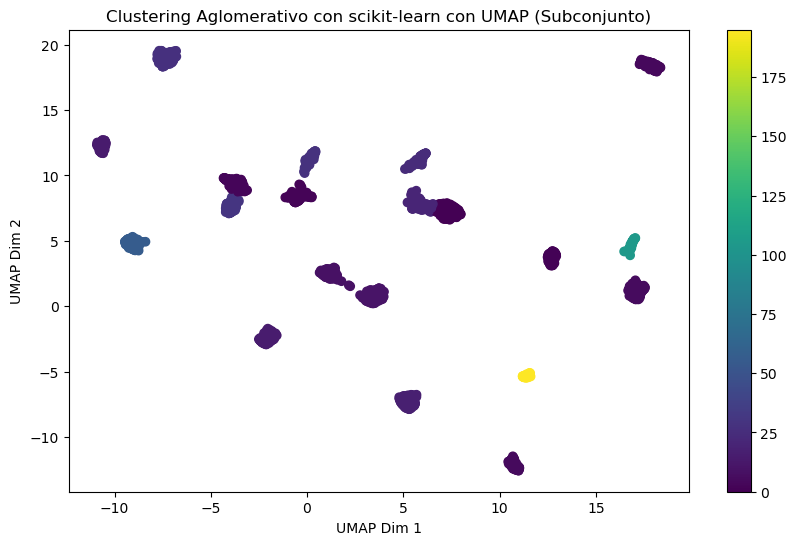

In [98]:
plt.figure(figsize=(10, 6))
plt.scatter(umap_data_subset[:, 0], umap_data_subset[:, 1], c=agg_labels, cmap='viridis')
plt.title('Clustering Aglomerativo con scikit-learn con UMAP (Subconjunto)')
plt.xlabel('UMAP Dim 1')
plt.ylabel('UMAP Dim 2')
plt.colorbar()
plt.show()

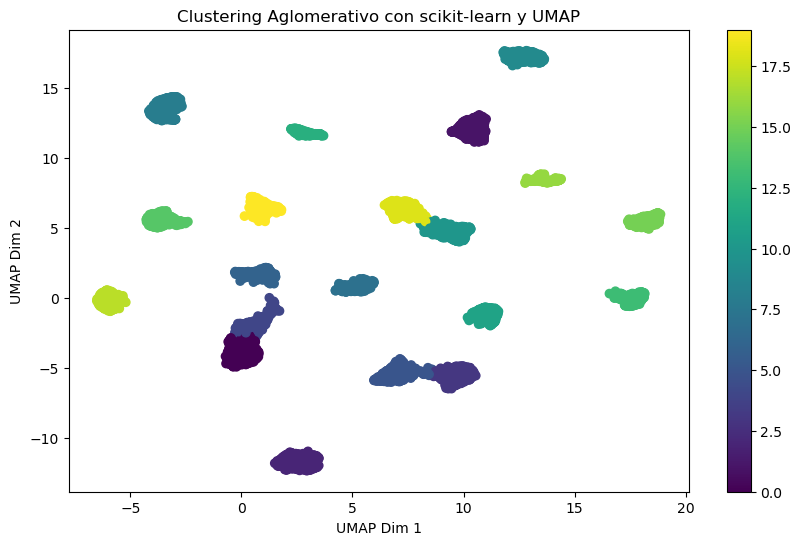

In [99]:
plt.figure(figsize=(10, 6))
plt.scatter(umap_data[:, 0], umap_data[:, 1], c=agg_labels_sklearn, cmap='viridis')
plt.title('Clustering Aglomerativo con scikit-learn y UMAP')
plt.xlabel('UMAP Dim 1')
plt.ylabel('UMAP Dim 2')
plt.colorbar()
plt.show()

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

def get_distance_measure(M):
    if M == 'euclidean':
        return lambda cluster1, cluster2: np.linalg.norm(np.mean(cluster1, axis=0) - np.mean(cluster2, axis=0))
    return None

class AgglomerativeHierarchicalClustering:
    def __init__(self, data, K, M='euclidean'):
        self.data = data
        self.N = len(data)
        self.K = K
        self.measure = get_distance_measure(M)
        self.clusters = self.init_clusters()
        self.distances = self.calculate_initial_distances()

    def init_clusters(self):
        return {i: [point] for i, point in enumerate(self.data)}

    def calculate_initial_distances(self):
        dist_matrix = squareform(pdist(self.data, 'euclidean'))
        distances = {(i, j): dist_matrix[i, j] for i in range(self.N) for j in range(i+1, self.N)}
        return distances

    def find_closest_clusters(self):
        
        closest_clusters = min(self.distances, key=self.distances.get)
        return closest_clusters

    def merge_and_form_new_clusters(self, ci_id, cj_id):
        new_cluster_id = min(ci_id, cj_id)
        old_cluster_id = max(ci_id, cj_id)

 
        self.clusters[new_cluster_id] += self.clusters[old_cluster_id]
        del self.clusters[old_cluster_id]

       
        keys_to_remove = [key for key in self.distances if old_cluster_id in key]
        for key in keys_to_remove:
            del self.distances[key]

        new_distances = {}
        for cluster_id in self.clusters:
            if cluster_id != new_cluster_id:
                new_distance = self.measure(self.clusters[new_cluster_id], self.clusters[cluster_id])
                new_distances[(min(new_cluster_id, cluster_id), max(new_cluster_id, cluster_id))] = new_distance

        self.distances.update(new_distances)

    def run_algorithm(self):
        while len(self.clusters) > self.K:
            ci_id, cj_id = self.find_closest_clusters()
            self.merge_and_form_new_clusters(ci_id, cj_id)

    def get_cluster_labels(self):
        labels = np.zeros(self.N)
        for cluster_id, points in self.clusters.items():
            for point in points:
                point_idx = np.where(np.all(self.data == point, axis=1))[0][0]
                labels[point_idx] = cluster_id
        return labels

    def print_clusters(self):
        for cluster_id, points in self.clusters.items():
            print(f"Cluster: {cluster_id}")
            for point in points:
                print(f"    {point}")



Tiempo de ejecución de la implementación personalizada en subconjunto: 4441.22 segundos


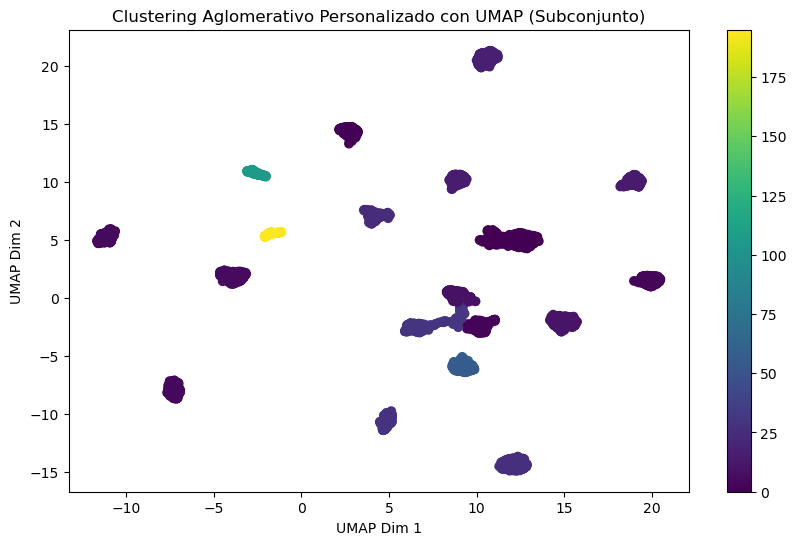

In [ ]:

import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
import umap


subset_size = 5000
X_train_subset = X_train.iloc[:subset_size, :]
Y_train_subset = Y_train.iloc[:subset_size, :]


scaler = PowerTransformer(method='yeo-johnson')
normalized_data_subset = scaler.fit_transform(X_train_subset)


umap_reducer = umap.UMAP(n_components=2)
umap_data_subset = umap_reducer.fit_transform(normalized_data_subset)


K = 20 
M = 'euclidean'

start_time = time.time()
agg_clustering = AgglomerativeHierarchicalClustering(umap_data_subset, K, M)
agg_clustering.run_algorithm()
agg_labels_subset = agg_clustering.get_cluster_labels()
end_time = time.time()



plt.figure(figsize=(10, 6))
plt.scatter(umap_data_subset[:, 0], umap_data_subset[:, 1], c=agg_labels_subset, cmap='viridis')
plt.title('Clustering Aglomerativo Personalizado con UMAP (Subconjunto)')
plt.xlabel('UMAP Dim 1')
plt.ylabel('UMAP Dim 2')
plt.colorbar()
plt.show()